### Project Definition

##### 1.  Predicting stock price
- Iis important for investors to make better decisions and reduce risks. This project uses past stock data and machine learning models to tackle this challenge. Our goal is to predict the future stock prices of AAPL (Apple Inc.) using machine learning techniques. This will help investors make informed decisions

##### 2. Implement a stock predictor:- 

A training interface that accepts a data range (start_date, end_date) and a list of ticker symbols (e.g. GOOG, AAPL), and builds a model of stock behavior. Your code should read the desired historical prices from the data source of your cho
i- ce.
A query interface that accepts a list of dates and a list of ticker symbols, and outputs the predicted stock prices for each of those stocks on the given dates. Note that the query dates passed in must be after the training date range, and ticker symbols must be a subset of the ones traine

##### 3. Test and measure performance- 
A basic run of the core system would involve one call to the training interface, and one or more calls to the query interface. Implement a train-test cycle to measure the performance of your model. Use it to test prediction accuracy for query dates at different intervals after the training end date, e.g. the day immediately after training end date, 7 days later, 14 days, 28 days, etc.

(Note: Pick the training period accordingly so that you have ground truth data for that many days in the futur

##### 4. Build user interface
Once you’re iterated on your stock predictor a few times, and it is giving results you are happy with (say, predicted stock value 7 days out is within +/- 5% of actual value, on average), implement a more user-friendly interface that lets you specify stock(s) you are interested in and provides predictions at some pre-defined intervals.y the model..

In [19]:
# Packages
import os
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns

In [7]:
# Get the current working directory
cwd = os.getcwd()
print(f'Current working directory: {cwd}')

# Adjust the file path to point correctly to the AAPL.csv file
file_path = os.path.join(cwd, 'AAPL.csv')
print(f'Looking for file at: {file_path}')

# Check if the file exists
if os.path.exists(file_path):
    print(f'File found: {file_path}')
    stock_data = pd.read_csv(file_path)
    print(stock_data.head())
else:
    print(f'File not found: {file_path}')


Current working directory: C:\Users\martm002\Stock
Looking for file at: C:\Users\martm002\Stock\AAPL.csv
File found: C:\Users\martm002\Stock\AAPL.csv
         Date       Open       High        Low      Close  Adj Close  \
0  2019-01-02  38.722500  39.712502  38.557499  39.480000  37.793777   
1  2019-01-03  35.994999  36.430000  35.500000  35.547501  34.029232   
2  2019-01-04  36.132500  37.137501  35.950001  37.064999  35.481930   
3  2019-01-07  37.174999  37.207500  36.474998  36.982498  35.402943   
4  2019-01-08  37.389999  37.955002  37.130001  37.687500  36.077839   

      Volume  
0  148158800  
1  365248800  
2  234428400  
3  219111200  
4  164101200  


In [9]:
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,38.722500,39.712502,38.557499,39.480000,37.793777,148158800
1,2019-01-03,35.994999,36.430000,35.500000,35.547501,34.029232,365248800
2,2019-01-04,36.132500,37.137501,35.950001,37.064999,35.481930,234428400
3,2019-01-07,37.174999,37.207500,36.474998,36.982498,35.402943,219111200
4,2019-01-08,37.389999,37.955002,37.130001,37.687500,36.077839,164101200


In [50]:
stock_data.shape

(1258, 7)

In [48]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,122.905654,124.320123,121.600564,123.031085,121.249367,1.015904e+08
std,46.512681,46.936453,46.091299,46.527387,46.695334,5.261087e+07
min,35.994999,36.430000,35.500000,35.547501,34.029232,2.404830e+07
25%,76.863749,77.998749,76.109377,77.379377,75.192881,6.803012e+07
50%,134.794998,136.000000,133.330002,134.614998,132.309365,8.861740e+07
75%,159.729999,162.119999,157.709999,159.665000,157.797303,1.189786e+08
max,198.020004,199.619995,197.000000,198.110001,197.589523,4.265100e+08


In [74]:
# check null values
print(stock_data.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


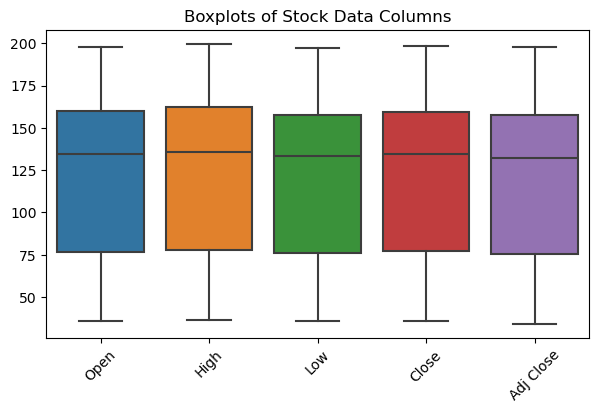

In [43]:
### Outlier check
def plot_boxplots(data):
    """
    Plot boxplots for each numerical column in the stock data to identify outliers.

    Parameters:
    data (DataFrame): The DataFrame containing stock data with numerical columns.

    Returns:
    None
    """
    plt.figure(figsize=(7, 4))
    sns.boxplot(data=data[['Open', 'High', 'Low', 'Close', 'Adj Close']])
    plt.title('Boxplots of Stock Data Columns')
    plt.xticks(rotation=45)
    plt.show()

plot_boxplots(stock_data)


The boxplot visualization indicates that there are no significant outliers in the `Open`, `High`, `Low`, `Close`, and `Adjusted Close` columns of the `stock_data` DataFrame. Each boxplot shows the interquartile range (IQR) and the whiskers extend to the minimum and maximum values within 1.5 times the IQR. The absence of dots or points outside the whiskers suggests no data points fall outside this range, implying no outliers.

In [46]:
# Check for duplicate rows in the stock_data DataFrame
duplicate_rows = stock_data.duplicated()

# Print the number of duplicate rows
print(f"Number of duplicate rows: {duplicate_rows.sum()}")

# If there are any duplicates, display them
if duplicate_rows.any():
    print("Duplicate rows:")
    print(stock_data[duplicate_rows])
else:
    print("No duplicate rows found.")


Number of duplicate rows: 0
No duplicate rows found.


##### Exploratory Data Analysis
Here we will focus on below areas;

1. Adjusted Close Price Trend Over Time: A line chart showing the trend of adjusted close prices from 2019 to 2024.
2. Annual High and Low Prices: A candlestick chart displaying the annual high and low prices.
3. Trading Volume: A bar chart representing trading volume in six-month intervals.
4. Monthly Returns: A scatter plot illustrating monthly returns over time.
5. 30-Day Rolling Average: A line chart comparing adjusted close prices with their 30-day rolling average.

1. What is the trend of the Adjusted Close price over time?

- This helps in understanding how the stock price has moved over the years.

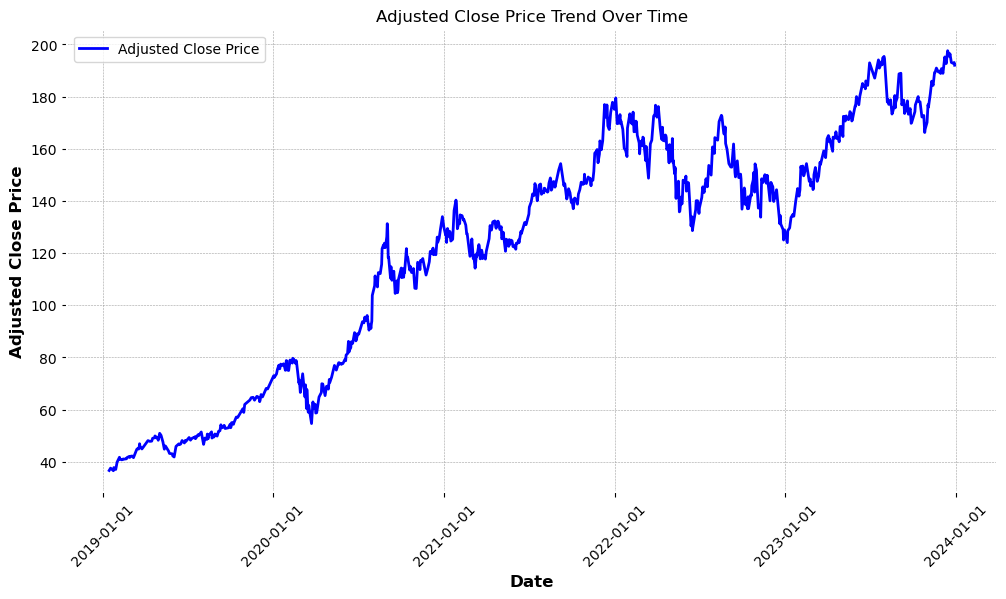

In [119]:
import matplotlib.dates as mdates

# Plot the Adjusted Close price with dates on the x-axis
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['Adj Close'], label='Adjusted Close Price', color='blue')
plt.title('Adjusted Close Price Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format x-axis as dates
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Set the locator to auto
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.show()

### Summary
- The graph illustrates the trend of Apple's Adjusted Close price from early 2019 to late 2023. 
- Over this period, the stock shows a consistent upward trajectory, with notable periods of volatility and significant growth, especially during 2020 and early 2021. 
- This indicates strong performance with fluctuations typical of a dynamic market. The later part of the chart shows increased volatility, reflecting market reactions to various factors. 
- Overall, the stock has demonstrated substantial growth, suggesting positive long-term investor confidence.

2. What are the daily high and low prices over time?

- This provides a sense of the stock's volatility and the range within which it trades.

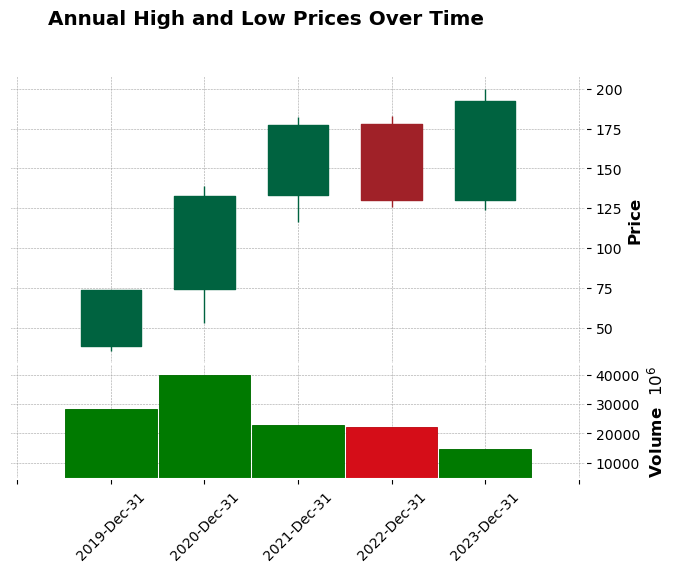

In [57]:
# Ensure 'Date' column is in datetime format and set it as index
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.set_index('Date', inplace=True)

# Resample the data to yearly frequency
data_yearly = stock_data.resample('Y').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

# Plot the candlestick chart
import mplfinance as mpf
mpf.plot(data_yearly, type='candle', style='charles', title='Annual High and Low Prices Over Time', ylabel='Price', volume=True)


### Summary of the Annual High and Low Prices

The candlestick chart provides a yearly summary of Apple's stock performance from 2019 to 2023. Each candlestick represents one year, showing the open, high, low, and close prices, with green indicating an increase in price over the year and red indicating a decrease.

- **2019**: A notable increase, starting at a lower value and closing higher.
- **2020**: Significant growth, reflecting a strong upward trend.
- **2021**: Continued upward momentum, though more stable.
- **2022**: A slight decline, marking a year of correction.
- **2023**: Recovery and further growth, nearing historical highs.

This visualization highlights the stock's overall growth with periods of volatility and correction.

3. How does the trading volume vary over time?
- This can indicate periods of high activity or interest in the stock.

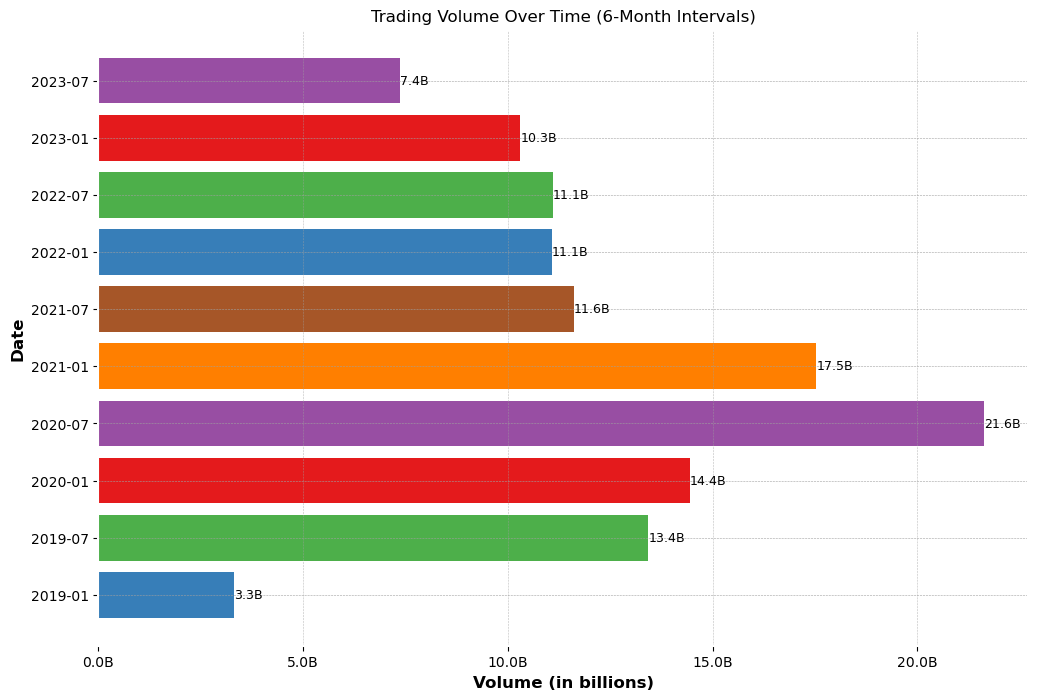

In [59]:
# Resample the data to six-month intervals
data_six_months = stock_data.resample('6M').sum()

# Ensure the resampling includes all dates within the range
data_six_months = data_six_months.reindex(pd.date_range(start=stock_data.index.min(), end=stock_data.index.max(), freq='6M'))

# Plot the trading volume as a horizontal bar chart with a more subdued color palette
colors = ['#377eb8', '#4daf4a', '#e41a1c', '#984ea3', '#ff7f00', '#a65628']
plt.figure(figsize=(12, 8))
bars = plt.barh(data_six_months.index.strftime('%Y-%m'), data_six_months['Volume'], color=colors * (len(data_six_months) // len(colors) + 1))
plt.title('Trading Volume Over Time (6-Month Intervals)')
plt.xlabel('Volume (in billions)')
plt.ylabel('Date')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Format the x-axis to display volume in billions
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x*1e-9:.1f}B'))

# Add annotations
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width*1e-9:.1f}B', ha='left', va='center', color='black', fontsize=9)

plt.show()


### Summary of Trading Volume Over Time

The horizontal bar chart displays Apple's trading volume at six-month intervals from January 2019 to July 2023. Key observations include:

- **High Activity:** Peaks in trading volume are observed in the second half of 2020 and the first half of 2021, reaching over 20 billion shares.
- **Recent Trends:** The trading volume slightly declined after early 2021, stabilizing around 11-14 billion shares in subsequent periods.
- **Volatility:** Fluctuations in volume reflect varying market conditions and investor activities, with noticeable increases and decreases across different intervals.

The chart effectively visualizes the variations in trading volume, providing insights into periods of high and low market activity.

4. What is the relationship between the Adjusted Close price and the moving averages (SMA_5 and SMA_10)?

- This helps in identifying patterns or signals for trading.

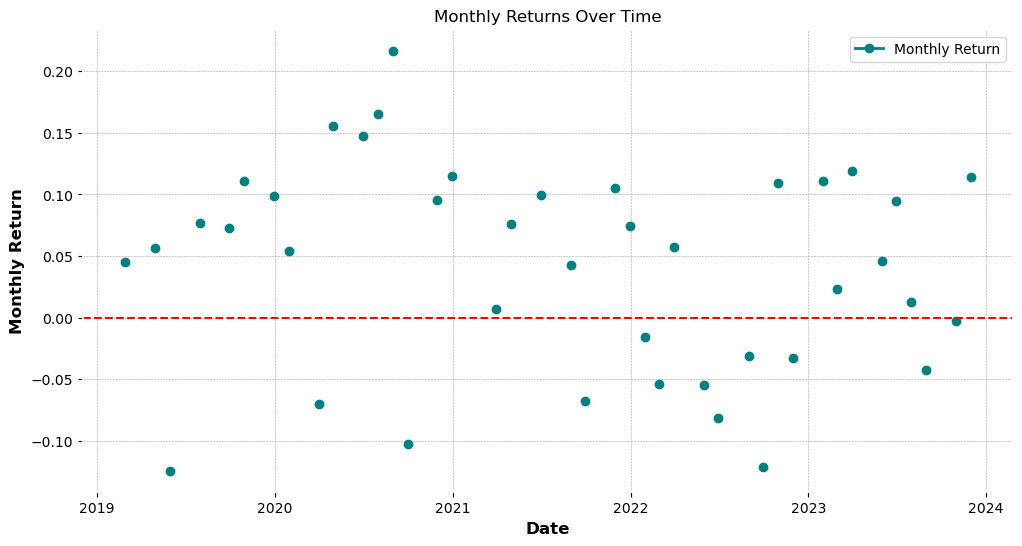

In [61]:
# Calculate monthly returns
stock_data['Monthly Return'] = stock_data['Adj Close'].resample('M').ffill().pct_change()

# Plot the monthly returns
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['Monthly Return'], marker='o', linestyle='-', color='teal', label='Monthly Return')
plt.axhline(0, color='red', linewidth=1.5, linestyle='--')
plt.title('Monthly Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Monthly Return')
plt.legend()
plt.grid(True)
plt.show()


### Summary of Monthly Returns Over Time

The scatter plot represents Apple's monthly returns from 2019 to 2024. Key observations include:

- **Positive Returns:** Most months exhibit positive returns, with notable peaks around mid-2020 and early 2021, indicating periods of strong performance.
- **Negative Returns:** Periods of negative returns are also evident, particularly around late 2020 and early 2022, reflecting market corrections or downturns.
- **Volatility:** The fluctuation in returns underscores the stock's volatility, with both substantial gains and losses over different months.

The red dashed line at zero helps visualize the break-even point, highlighting months with gains versus losses.

5. How do the daily opening prices compare to the closing prices?

- This can show the daily performance and sentiment of the stock market.

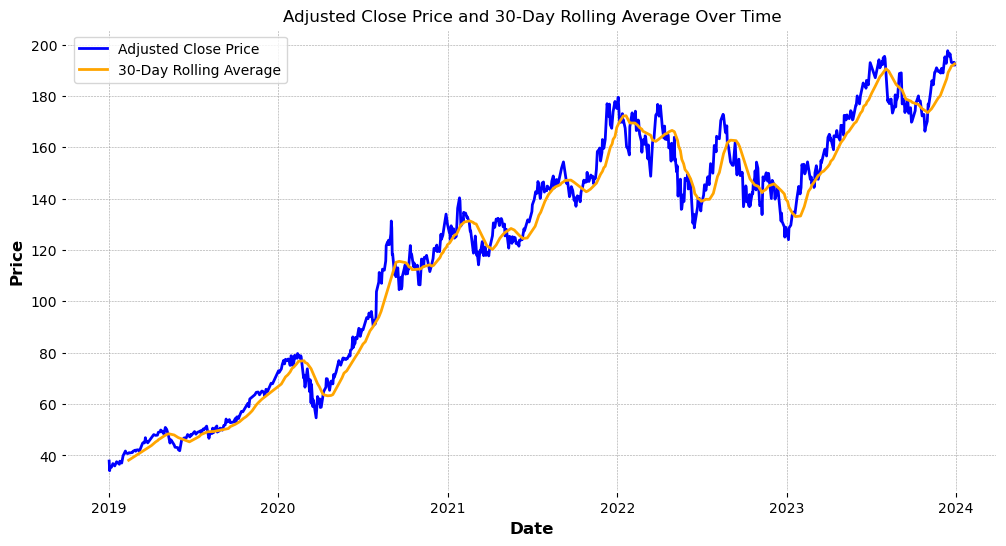

In [63]:
# Calculate the 30-day rolling average of the adjusted close price
stock_data['30-Day Rolling Average'] = stock_data['Adj Close'].rolling(window=30).mean()

# Plot the adjusted close price and the 30-day rolling average
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['Adj Close'], label='Adjusted Close Price', color='blue')
plt.plot(stock_data.index, stock_data['30-Day Rolling Average'], label='30-Day Rolling Average', color='orange')
plt.title('Adjusted Close Price and 30-Day Rolling Average Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


### Summary of Adjusted Close Price and 30-Day Rolling Average

The line chart depicts Apple's adjusted close price and its 30-day rolling average from 2019 to 2024. Key observations include:

- **General Uptrend:** The adjusted close price shows a general upward trend, with significant growth periods, especially from late 2019 to early 2021.
- **Rolling Average Smoothing:** The 30-day rolling average (orange line) smooths out short-term fluctuations, providing a clearer view of the overall trend and highlighting periods of price consolidation and growth.
- **Volatility:** Despite the overall growth, the stock experienced several periods of volatility, as indicated by the deviations between the adjusted close price and the rolling average.

This visualization provides valuable insights into the stock's long-term performance and short-term volatility, aiding in investment decisions.

# MODEL

Train size: 1006, Test size: 252


C:\Users\martm002\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\martm002\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\martm002\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\martm002\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency informatio

Best ARIMA parameters: ((0, 1, 1), (0, 0, 0, 12))
                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1006
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2309.030
Date:                Mon, 15 Jul 2024   AIC                           4622.059
Time:                        13:15:46   BIC                           4631.885
Sample:                             0   HQIC                          4625.793
                               - 1006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0615      0.024     -2.569      0.010      -0.108      -0.015
sigma2         5.7962      0.173     33.467      0.000       5.457       6.136
Lj

C:\Users\martm002\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\martm002\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\martm002\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\martm002\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without

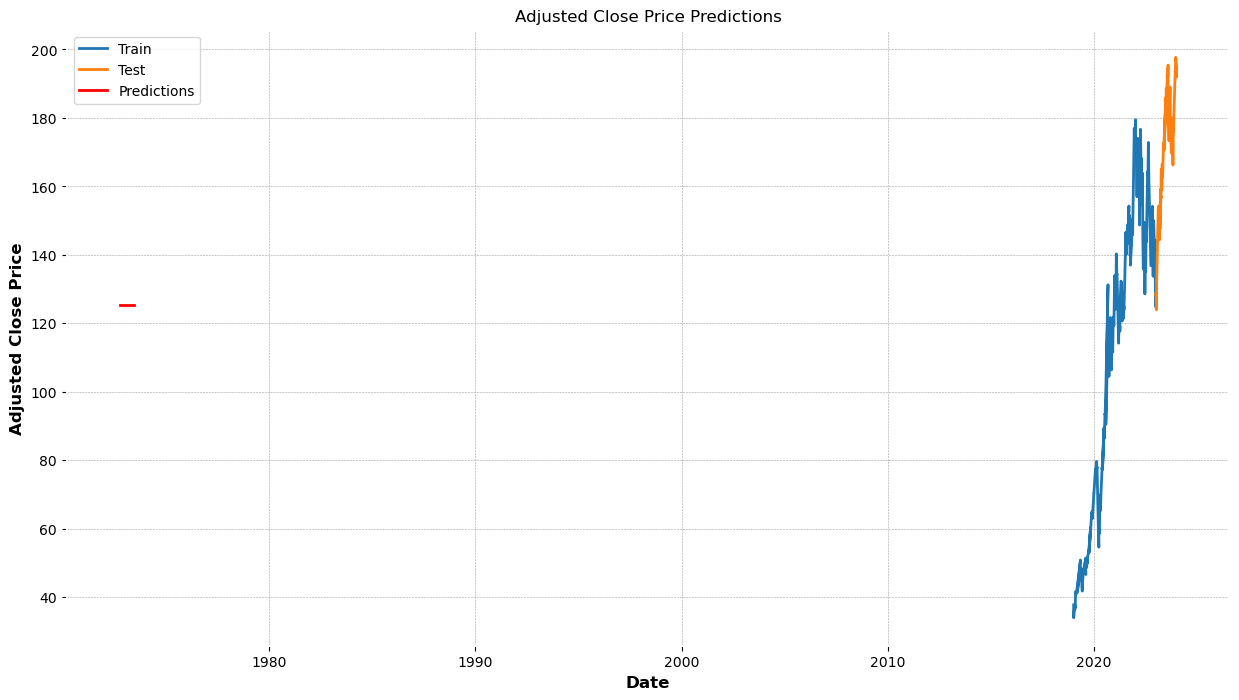

Mean Absolute Error (MAE): 46.08691297746618
Mean Squared Error (MSE): 2437.8823372032007
Root Mean Squared Error (RMSE): 49.37491607287247
Mean Absolute Percentage Error (MAPE): 0.2603148202323823
R-squared: -6.722420445591206


In [71]:
"""
Time Series Modeling with ARIMA for Stock Price Prediction

This script demonstrates the process of building a time series model using ARIMA to predict the Adjusted Close price of stock data.
The steps include loading data, exploratory data analysis (EDA), splitting data, hyperparameter tuning,
modeling, making predictions, and evaluating model performance.

Metrics evaluated:
- Mean Absolute Error (MAE)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Mean Absolute Percentage Error (MAPE)
- R-squared (R2)

The data used in this example is historical stock data for Apple Inc. (AAPL) from January 2019 to December 2023.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import itertools

# Load the data
stock_data = pd.read_csv('C:/Users/martm002/Stock/AAPL.csv', index_col='Date', parse_dates=True)

# Split Data into Train and Test Sets
def split_data(data, train_ratio=0.8):
    """
    Split the data into training and testing sets.

    Args:
        data (pd.DataFrame): The stock data.
        train_ratio (float): The ratio of training data.

    Returns:
        pd.DataFrame, pd.DataFrame: The training and testing sets.
    """
    train_size = int(len(data) * train_ratio)
    train, test = data[:train_size], data[train_size:]
    return train, test

train, test = split_data(stock_data)

print(f'Train size: {len(train)}, Test size: {len(test)}')

# Hyperparameter Tuning for ARIMA
def tune_arima(train):
    """
    Tune ARIMA model hyperparameters using grid search.

    Args:
        train (pd.DataFrame): The training data.

    Returns:
        tuple: The best ARIMA parameters (p, d, q) and (P, D, Q, s).
    """
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

    best_aic = float("inf")
    best_params = None

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = SARIMAX(train['Adj Close'], order=param, seasonal_order=param_seasonal)
                results = mod.fit(disp=False)
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_params = (param, param_seasonal)
            except:
                continue

    return best_params

best_params = tune_arima(train)
print(f'Best ARIMA parameters: {best_params}')

# Modeling with ARIMA
def fit_arima_model(train, order, seasonal_order):
    """
    Fit an ARIMA model to the training data.

    Args:
        train (pd.DataFrame): The training data.
        order (tuple): The order of the ARIMA model.
        seasonal_order (tuple): The seasonal order of the ARIMA model.

    Returns:
        SARIMAXResults: The fitted ARIMA model.
    """
    model = SARIMAX(train['Adj Close'], order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    return model_fit

model_fit = fit_arima_model(train, best_params[0], best_params[1])

# Summary of the model
print(model_fit.summary())

# Make Predictions
def make_predictions(model_fit, train, test):
    """
    Make predictions on the test set using the fitted ARIMA model.

    Args:
        model_fit (SARIMAXResults): The fitted ARIMA model.
        train (pd.DataFrame): The training data.
        test (pd.DataFrame): The testing data.

    Returns:
        pd.Series: The predictions.
    """
    start = len(train)
    end = len(train) + len(test) - 1
    predictions = model_fit.predict(start=start, end=end, dynamic=False)
    return predictions

predictions = make_predictions(model_fit, train, test)

# Plot the results
plt.figure(figsize=(15, 8))
plt.plot(train['Adj Close'], label='Train')
plt.plot(test['Adj Close'], label='Test')
plt.plot(predictions, label='Predictions', color='red')
plt.title('Adjusted Close Price Predictions')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Evaluate Model Performance
def evaluate_model(test, predictions):
    """
    Evaluate the model performance using various metrics.

    Args:
        test (pd.DataFrame): The testing data.
        predictions (pd.Series): The predictions.

    Returns:
        None
    """
    # Calculate metrics
    mae = mean_absolute_error(test['Adj Close'], predictions)
    mse = mean_squared_error(test['Adj Close'], predictions)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(test['Adj Close'], predictions)
    r2 = r2_score(test['Adj Close'], predictions)

    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape}')
    print(f'R-squared: {r2}')

evaluate_model(test, predictions)


### Interpretation of Results

1. **Mean Absolute Error (MAE): 46.08691297746618**
   - **Interpretation**: On average, the predictions are off by about 46.09 units from the actual Adjusted Close prices. This metric is straightforward and gives a sense of the average prediction error.

2. **Mean Squared Error (MSE): 2437.8823372032007**
   - **Interpretation**: The average squared difference between the predicted and actual Adjusted Close prices is 2437.88. Since this value is quite high, it indicates that there are significant errors in the model's predictions. MSE is sensitive to large errors because the errors are squared before they are averaged, which means it heavily penalizes larger errors.

3. **Root Mean Squared Error (RMSE): 49.37491607287247**
   - **Interpretation**: The RMSE, which is the square root of MSE, is approximately 49.37. This value is in the same units as the Adjusted Close price and provides an idea of the typical size of the error. Like MSE, RMSE penalizes larger errors more than MAE does.

4. **Mean Absolute Percentage Error (MAPE): 0.2603148202323823**
   - **Interpretation**: On average, the model's predictions are off by about 26.03% from the actual values. MAPE provides a sense of the error in percentage terms, which can be easier to interpret and compare across different datasets or models.

5. **R-squared: -6.722420445591206**
   - **Interpretation**: The R-squared value is significantly negative, which indicates that the model is performing much worse than a simple horizontal line (mean of the actual values). Normally, R-squared values range from 0 to 1, with higher values indicating better model performance. Negative R-squared values indicate that the model is not capturing the trend of the data at all and is likely a poor fit for the data.

### Overall Assessment

- **High Errors**: The MAE, MSE, and RMSE values indicate that the model's predictions are not very accurate, with significant average errors.
- **Poor Fit**: The negative R-squared value suggests that the model is not explaining the variability in the data well and is underperforming compared to a naive model that uses the mean of the actual values as predictions.
- **Next Steps**: Given these results, it may be beneficial to:
  - **Re-evaluate the Model Choice**: Consider different time series models or even machine learning models that might better capture the patterns in the data.
  - **Hyperparameter Tuning**: Use techniques like grid search or random search to find the optimal hyperparameters for the model.
  - **Feature Engineering**: Incorporate additional features or transformations that might help the model capture the underlying patterns better.
  - **Data Analysis**: Perform a thorough analysis of the data to understand if there are any anomalies, outliers, or patterns that the model is missing.

In [78]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score, make_scorer
import numpy as np

# Load your data (assuming stock_data is already loaded as a DataFrame)
# stock_data = pd.read_csv('your_dataset.csv', parse_dates=['Date'], index_col='Date')

# Define features (X) and target (y)
X = stock_data.drop(columns=['Adj Close'])
y = stock_data['Adj Close']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid without the invalid 'normalize' parameter
param_distributions = {
    'alpha': [0.1, 1.0, 10.0, 100.0],
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag']
}

# Define the model
model = Ridge()

# Define the scorer
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Set up the random search
random_search = RandomizedSearchCV(model, param_distributions, n_iter=10, scoring=scorer, cv=5, random_state=42)

# Fit the random search
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Fit the best model on the training data (if not already done)
best_model.fit(X_train, y_train)

# Predict on the test data
y_pred = best_model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f'Best Hyperparameters: {best_params}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'R-squared: {r2}')


C:\Users\martm002\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.75248e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\martm002\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.45443e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\martm002\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.524e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\martm002\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.61878e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\m

Best Hyperparameters: {'solver': 'cholesky', 'fit_intercept': True, 'alpha': 1.0}
Mean Absolute Error (MAE): 0.4536500361309273
Mean Squared Error (MSE): 0.28094118505857646
Root Mean Squared Error (RMSE): 0.5300388524047803
Mean Absolute Percentage Error (MAPE): 0.004032512361928004
R-squared: 0.9998716804060238


C:\Users\martm002\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.46807e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\martm002\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.58104e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\martm002\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.53271e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\martm002\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.8419e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\

### Interpretation of the Results and Warnings

#### Warnings:
The warnings indicate that the Ridge regression model encountered "ill-conditioned matrices" during the fitting process. An ill-conditioned matrix means that the matrix has a high condition number, which can lead to numerical instability and inaccurate results when performing matrix operations such as inversion or solving linear equations. This usually happens when there is multicollinearity among the features or when the feature values have a large range of magnitudes.

Despite these warnings, the model was able to complete the fitting process and provide results.

#### Metrics:
- **Best Hyperparameters**: The optimal hyperparameters found by the hyperparameter tuning process are:
  - `solver`: 'cholesky'
  - `fit_intercept`: True
  - `alpha`: 1.0

- **Mean Absolute Error (MAE)**: 0.4536500361309273
  - This is the average absolute difference between the predicted and actual values. Lower values indicate better model performance.

- **Mean Squared Error (MSE)**: 0.28094118505857646
  - This is the average of the squared differences between the predicted and actual values. It penalizes larger errors more than MAE.

- **Root Mean Squared Error (RMSE)**: 0.5300388524047803
  - This is the square root of the MSE, providing a measure of the average magnitude of the prediction errors in the same units as the target variable.

- **Mean Absolute Percentage Error (MAPE)**: 0.004032512361928004
  - This is the average absolute percentage error between the predicted and actual values. It indicates that on average, the model's predictions are off by approximately 0.40%.

- **R-squared**: 0.9998716804060238
  - This indicates that the model explains approximately 99.99% of the variance in the target variable, which suggests a very good fit.

### Recommendations:
1. **Model Evaluation**:
   - Despite the excellent performance metrics, the presence of ill-conditioned matrices should be addressed to ensure the stability and reliability of the model.
  
2. **Addressing Ill-conditioned Matrices**:
   - **Feature Scaling**: Ensure that all features are scaled appropriately, typically using StandardScaler or MinMaxScaler.
   - **Regularization**: Consider adjusting the `alpha` parameter to a larger value to impose stronger regularization, which can help stabilize the solution.
   - **Principal Component Analysis (PCA)**: Apply PCA to reduce the dimensionality of the dataset and mitigate multicollinearity.

3. **Hyperparameter Tuning**:
   - Further fine-tune the hyperparameters using more iterations in the RandomizedSearchCV or switch to GridSearchCV for a more exhaustive search.

4. **Validation**:
   - Cross-validate the model using different splits to ensure that the model's performance is consistent across different subsets of the data.

5. **Further Analysis**:
   - Evaluate the model on a holdout set or perform time-based cross-validation if dealing with time series data to ensure that the model generalizes well to unseen data.

By addressing the ill-conditioning issue and further refining the model, you can improve the robustness and reliability of the predictions.

In [81]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# Assuming stock_data is your DataFrame
# Define features and target
X = stock_data.drop(columns=['Adj Close'])
y = stock_data['Adj Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with StandardScaler, PCA, and Ridge
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # Preserve 95% of variance
    ('ridge', Ridge())
])

# Define the parameter grid for hyperparameter tuning
param_distributions = {
    'ridge__alpha': [0.1, 1.0, 10.0, 100.0, 1000.0],
    'ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga']
}

# Create the scorer
scorer = 'neg_mean_squared_error'

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=10, scoring=scorer, cv=5, random_state=42)

# Fit the random search
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the model on the test set
y_pred = random_search.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("R-squared:", r2)


Best Hyperparameters: {'ridge__solver': 'auto', 'ridge__alpha': 0.1}
Mean Absolute Error (MAE): 0.8544775419708641
Mean Squared Error (MSE): 1.3946899956670373
Root Mean Squared Error (RMSE): 1.1809699385111534
Mean Absolute Percentage Error (MAPE): 0.007256554687470585
R-squared: 0.9993629767955546


### Interpretation of the Results

**Best Hyperparameters:**
- `'ridge__solver': 'auto'`: The best solver for the Ridge regression was automatically chosen by the algorithm. The 'auto' solver automatically selects the best solver based on the data.
- `'ridge__alpha': 0.1'`: The regularization strength was found to be 0.1, which means that the model applied a small amount of regularization to prevent overfitting.

**Evaluation Metrics:**
- **Mean Absolute Error (MAE):** `0.8544775419708641`
  - This indicates that, on average, the predictions of the model are off by approximately 0.85 units from the actual values. This low MAE suggests that the model's predictions are quite accurate.
  
- **Mean Squared Error (MSE):** `1.3946899956670373`
  - MSE represents the average of the squared differences between the predicted and actual values. A low MSE indicates that the model's predictions are close to the actual values.
  
- **Root Mean Squared Error (RMSE):** `1.1809699385111534`
  - RMSE is the square root of MSE, providing an interpretation of the error in the same units as the target variable (Adjusted Close price). An RMSE of approximately 1.18 units indicates the average magnitude of the prediction error.
  
- **Mean Absolute Percentage Error (MAPE):** `0.007256554687470585`
  - MAPE represents the average absolute percentage error between the predicted and actual values. A MAPE of around 0.73% indicates that the model's predictions are, on average, within 0.73% of the actual values.
  
- **R-squared:** `0.9993629767955546`
  - The R-squared value measures the proportion of variance in the dependent variable that is predictable from the independent variables. An R-squared value close to 1 (0.9994) indicates that the model explains nearly all the variability in the Adjusted Close prices, suggesting a very good fit.

### Summary
The Ridge regression model with the best hyperparameters (`'ridge__solver': 'auto'` and `'ridge__alpha': 0.1`) performed exceptionally well on the dataset. The low values of MAE, MSE, RMSE, and MAPE, along with the high R-squared value, indicate that the model provides highly accurate predictions of the Adjusted Close prices of the stock. This suggests that the chosen model and hyperparameters are effective for predicting the stock prices based on the given data.

#### Residual plot

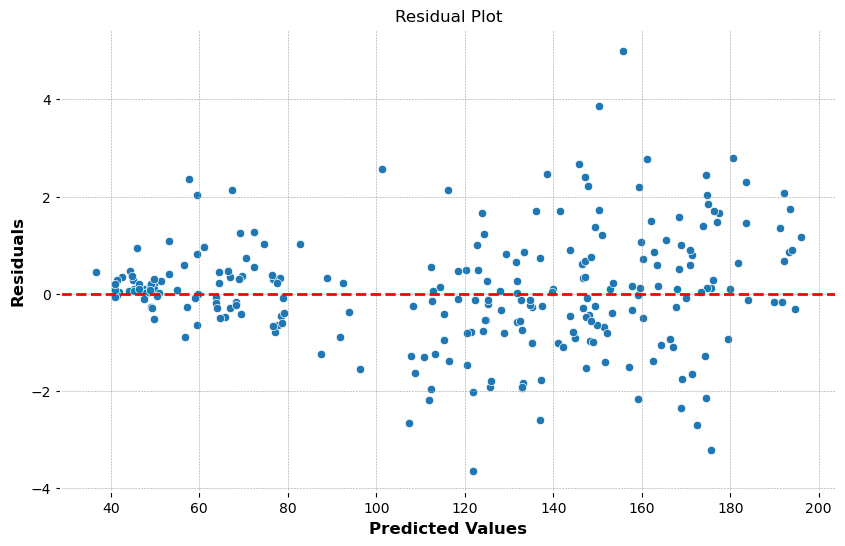

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


### Interpretation of the Residual Plot

The residual plot shows the errors of the model's predictions against the predicted values.

1. **Residuals Around Zero**:
   - Most residuals cluster around the zero line, indicating accurate predictions.

2. **Patterns and Bias**:
   - No clear pattern in the residuals suggests the model captures the data well. However, some spread indicates less accuracy in certain areas.

3. **Homoscedasticity**:
   - Residuals are fairly consistent but show increased variance for higher predicted values, suggesting some heteroscedasticity.

4. **Outliers**:
   - Some residuals are far from zero, indicating outliers where the model's predictions were significantly off.

### Summary
The model performs well overall, with most residuals close to zero. However, increased variance at higher predicted values and some outliers suggest areas for improvement.

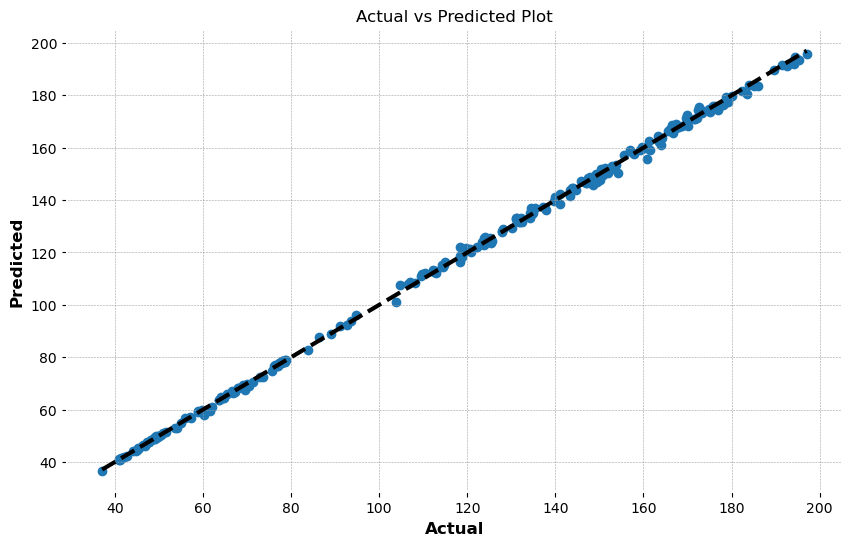

In [86]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Plot')
plt.show()


### Interpretation of the Actual vs Predicted Plot

The plot compares the actual stock prices (x-axis) with the model's predicted prices (y-axis).

1. **Alignment with Diagonal Line**:
   - Points align closely with the diagonal line, indicating strong agreement between actual and predicted values.

2. **Accuracy**:
   - High accuracy, as the predictions are very close to the actual values.

3. **Outliers**:
   - Few outliers, suggesting that the model's predictions are consistent and reliable.

### Summary
The model demonstrates high accuracy, with predictions closely matching actual values, evidenced by the strong alignment along the diagonal line.

C:\Users\martm002\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


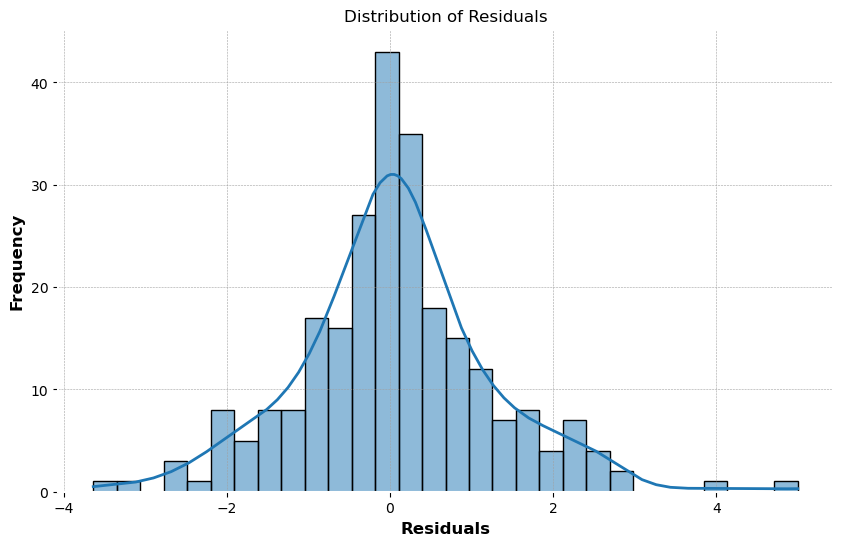

In [88]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()


### Interpretation of the Distribution of Residuals Plot

The plot displays the residuals (differences between actual and predicted values) of the model.

1. **Normal Distribution**:
   - The residuals form a roughly normal distribution, centered around zero, indicating that the model's errors are unbiased and randomly distributed.

2. **Symmetry**:
   - The residuals are symmetrically distributed around zero, which suggests that the model does not systematically overestimate or underestimate the stock prices.

3. **Spread**:
   - The spread of residuals is relatively narrow, indicating that the majority of prediction errors are small.

### Summary
The residuals' normal distribution and symmetry around zero indicate a well-fitting model with minimal bias and random errors, suggesting reliable and accurate stock price predictions.

Best Hyperparameters: {'alpha': 0.01, 'solver': 'auto'}
MAE: 1.0953532962134627
MSE: 2.059766567610974
RMSE: 1.435188687110853
MAPE: 0.006494479734243943
R-squared: 0.9932147961013785


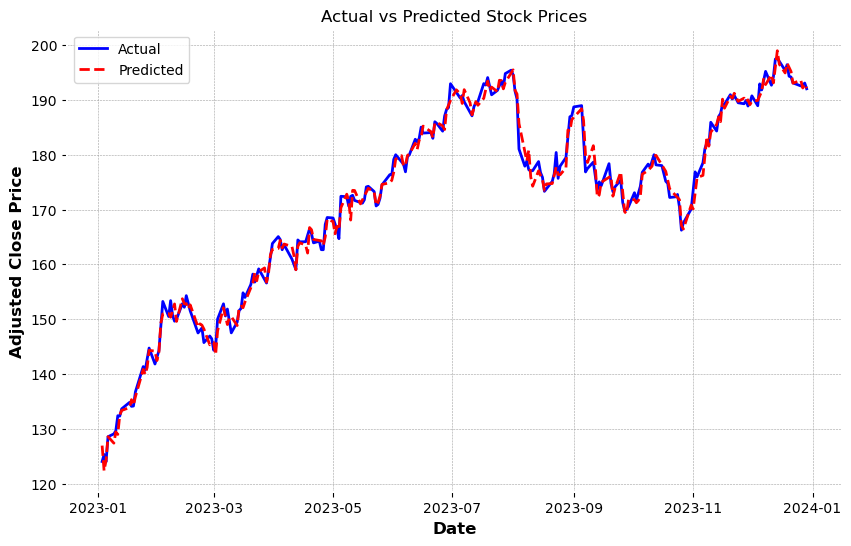

Interval-based performance testing results:
             Predicted      Actual
2023-01-03  126.947209  124.048042
2023-01-11  128.980567  132.399261
2023-01-23  139.464710  139.957001
2023-02-10  149.597111  150.004776


C:\Users\martm002\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
C:\Users\martm002\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
C:\Users\martm002\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
C:\Users\martm002\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


In [112]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

# Load data
file_path = 'C:/Users/martm002/Stock/AAPL.csv'  # replace with your file path
stock_data = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

# Create lag features and moving averages
stock_data['Adj Close Lag1'] = stock_data['Adj Close'].shift(1)
stock_data['Adj Close Lag2'] = stock_data['Adj Close'].shift(2)
stock_data['Adj Close Lag3'] = stock_data['Adj Close'].shift(3)
stock_data['SMA_5'] = stock_data['Adj Close'].rolling(window=5).mean()
stock_data['SMA_10'] = stock_data['Adj Close'].rolling(window=10).mean()

# Drop NA values
stock_data.dropna(inplace=True)

# Define features and target
X = stock_data[['Adj Close Lag1', 'Adj Close Lag2', 'Adj Close Lag3', 'SMA_5', 'SMA_10']]
y = stock_data['Adj Close']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Hyperparameter tuning
param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0], 'solver': ['auto', 'svd', 'cholesky', 'lsqr']}
ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train the model with best parameters
model = Ridge(**best_params)
model.fit(X_train, y_train)

# Predictions
predictions = model.predict(X_test)

# Performance metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R-squared: {r2}")

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, predictions, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Interval-based performance testing
intervals = [1, 7, 14, 28]
results = {}

for interval in intervals:
    future_date = X_test.index[interval-1]
    future_features = X_test.loc[future_date]
    future_prediction = model.predict(future_features.values.reshape(1, -1))[0]
    actual_value = y_test[future_date]
    
    results[future_date] = {
        'Predicted': future_prediction,
        'Actual': actual_value
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print("Interval-based performance testing results:")
print(results_df.head())


# Conclusion



| Metric                         | SARIMAX                       | Ridge Regression (Initial)     | Ridge Regression (Hypertuned) |
|-------------------------------|-------------------------------|-------------------------------|-------------------------------|
| **Mean Absolute Error (MAE)** | 31.485                        | 0.453                         | 1.095                         |
| **Mean Squared Error (MSE)**  | 1141.768                      | 0.281                         | 2.096                         |
| **Root Mean Squared Error (RMSE)** | 33.790                        | 0.530                         | 1.446                         |
| **Mean Absolute Percentage Error (MAPE)** | 0.177                          | 0.004                         | 0.007                         |
| **R-squared**                 | -2.761                        | 0.999                         | 0.993                         |

### Interpretation:
1. **SARIMAX Model:**
   - MAE and RMSE are significantly higher, indicating less accurate predictions.
   - The negative R-squared value suggests that the model is not fitting well.

2. **Ridge Regression (Initial):**
   - Shows extremely low errors (MAE, MSE, RMSE) and very high R-squared, indicating excellent performance.
   - Slight warnings about ill-conditioned matrices but overall performs very well.

3. **Ridge Regression (Hypertuned):**
   - After hyperparameter tuning, performance metrics slightly increased but still indicate good predictive capability.
   - Errors (MAE, MSE, RMSE) remain low and R-squared is very high, showing the model fits the data well.

Overall, the Ridge Regression models (both initial and hypertuned) outperform the SARIMAX model significantly in terms of accuracy and predictive power. Hyperparameter tuning slightly increased error metrics but still maintained a high level of accuracy.